# Building a Deepfake Detector using Deep Learning Models
This notebook demonstrates the development of a deepfake detection system using multiple pre-trained **CNN (Convolutional Neural Network)** models, such as **ResNet50**, **EfficientNetV2B0** and **Xception**, combined with **LSTM (Long Short-Term Memory)** networks for temporal analysis. The datasets used are **FaceForensics++**, **DFDC** and **Celeb-DF (v2)**. To ensure unbiased testing, the **Celeb-DF (v2)** dataset consists of completely unseen videos that are exclusively reserved for testing and are not included in the training or validation processes. `OpenCV` is utilized for video frame extraction and preprocessing while `dlib` is used for face detection and cropping.

## GPU Configuration and Verification with TensorFlow
To ensure TensorFlow is configured to effectively utilize the GPU for deep learning tasks, optimize memory usage and verify GPU support.

In [2]:
import tensorflow as tf

# Check if TensorFlow is built with CUDA support and list GPUs
print("TensorFlow CUDA Support:", tf.test.is_built_with_cuda())
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))

if physical_devices:
    try:
        for i, gpu in enumerate(physical_devices):
            # Enable memory growth for each GPU
            tf.config.experimental.set_memory_growth(gpu, True)
            print(f"Enabled memory growth for GPU {i}: {tf.config.experimental.get_device_details(gpu)['device_name']}")
    except RuntimeError as e:
        print("Error enabling GPU memory growth:", e)
else:
    print("No GPU detected. Ensure proper GPU setup.")

TensorFlow CUDA Support: True
Num GPUs Available: 1
Enabled memory growth for GPU 0: NVIDIA GeForce 940MX


## Importing Libraries and Setup
Importing all necessary libraries at the top to ensure better organization, easy debugging and smooth execution of the entire pipeline.

In [2]:
import os
import numpy as np
import pandas as pd
import gc
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

## 6. Sequence Generation

### 6.1 Defining Custom Sequence Generator for Testing

In [3]:
def non_stratified_data_generator(
    data_dir, batch_size, sequence_length, target_size=(224, 224), max_iterations=None):
    """
    Non-stratified data generator for testing purposes.

    This generator is designed to load, preprocess, and yield batches of video sequences
    without stratification, augmentation, or shuffling.

    Args:
        data_dir (str): Path to the dataset directory containing class subfolders ('real', 'fake').
        batch_size (int): Number of sequences per batch.
        sequence_length (int): Number of frames per sequence.
        target_size (tuple): Dimensions to resize each frame to (height, width).
        max_iterations (int): Maximum number of iterations for batch generation (useful for debugging).

    Yields:
        Tuple of (X, y): X is a batch of sequences, y is the corresponding labels.
    """
    print(f"\n--- Initializing Non-Stratified Data Generator (For Testing) ---")
    print(f"Data Directory: {data_dir}")
    print(f"Batch Size: {batch_size}, Sequence Length: {sequence_length}, Target Size: {target_size}\n")

    # Class directories and labels
    class_dirs = {"real": 0, "fake": 1}
    file_paths = {class_name: [] for class_name in class_dirs.keys()}

    # Collect image paths for each class
    print("Collecting image paths and labels...")
    for class_name, label in class_dirs.items():
        class_dir = os.path.join(data_dir, class_name)

        # Validate class directory
        if not os.path.exists(class_dir):
            print(f"Error: Class directory {class_dir} not found. Skipping.")
            continue

        print(f"Scanning directory: {class_dir}")
        for subdir, _, files in os.walk(class_dir):
            for file_name in files:
                if file_name.lower().endswith((".jpg", ".jpeg", ".png")):
                    file_paths[class_name].append((os.path.join(subdir, file_name), label))

        print(f"Collected {len(file_paths[class_name])} images for class '{class_name}'.")

    print("\nImage collection completed for all classes.")

    # Combine paths from all classes into a single list for non-stratified loading
    combined_paths = []
    for paths in file_paths.values():
        combined_paths.extend(paths)

    # Batch generation loop
    iterations = 0
    while max_iterations is None or iterations < max_iterations:
        X, y = [], []

        for i in range(batch_size):
            if len(combined_paths) < sequence_length:
                print("Warning: Not enough images to form sequences. Stopping the generator.")
                return

            # Select the first `sequence_length` images from the combined list
            sequence = []
            for _ in range(sequence_length):
                img_path, label = combined_paths.pop(0)
                img = cv2.imread(img_path)

                # Validate file loading
                if img is None:
                    print(f"Warning: Failed to load image: {img_path}. Skipping.")
                    continue

                # Preprocessing: Resize, normalize
                try:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                    img = cv2.resize(img, target_size)
                    img = img / 255.0  # Normalize to [0, 1]
                except Exception as e:
                    print(f"Error processing image {img_path}: {e}. Skipping.")
                    continue

                sequence.append(img)

            if len(sequence) == sequence_length:  # Only add valid sequences
                X.append(sequence)
                y.append(label)

        if len(X) > 0:  # Yield only if valid sequences exist in the batch
            yield np.array(X), np.array(y)
            iterations += 1

### 6.2 Initializing Data Generators for Testing

In [4]:
# Dataset directories
print("--- Setting Up Testing Dataset Paths ---")
base_dir = os.getcwd()
test_dir = os.path.join(base_dir, "Cropped_Faces", "test")
print(f"Testing Directory: {test_dir}\n")

# Hyperparameters for Testing
TEST_BATCH_SIZE = 8  # Recommended batch size is 8 (Reduce value according to need)
TEST_SEQUENCE_LENGTH = 10  # Recommended frames per sequence is 10 (Reduce value according to need)
TEST_TARGET_SIZE = (224, 224)  # Resize dimensions

# Initialize test generator
print("--- Creating Test Generator ---")
test_generator = non_stratified_data_generator(
    data_dir=test_dir,
    batch_size=TEST_BATCH_SIZE,
    sequence_length=TEST_SEQUENCE_LENGTH,
    target_size=TEST_TARGET_SIZE,
)
print("Testing generator created successfully.")

--- Setting Up Testing Dataset Paths ---
Testing Directory: C:\Users\atul\Cropped_Faces\test

--- Creating Test Generator ---
Testing generator created successfully.


### 6.3 Dynamic Calculation of Training, Validation and Testing Dataset Sizes

In [37]:
def count_images_in_class(directory, class_name):
    class_dir = os.path.join(directory, class_name)
    image_extensions = ('.jpg', '.jpeg', '.png')  # Supported image formats
    count = 0
    for root, _, files in os.walk(class_dir):
        count += sum(1 for file in files if file.lower().endswith(image_extensions))
    return count

def calculate_dataset_sizes(train_dir, val_dir):
    # Count for train
    train_real_count = count_images_in_class(train_dir, "real")
    train_fake_count = count_images_in_class(train_dir, "fake")
    train_dataset_size = train_real_count + train_fake_count

    # Count for val
    val_real_count = count_images_in_class(val_dir, "real")
    val_fake_count = count_images_in_class(val_dir, "fake")
    val_dataset_size = val_real_count + val_fake_count

    return train_real_count, train_fake_count, train_dataset_size, val_real_count, val_fake_count, val_dataset_size

def calculate_test_dataset_size(test_dir):
    # Count for val
    test_real_count = count_images_in_class(test_dir, "real")
    test_fake_count = count_images_in_class(test_dir, "fake")
    test_dataset_size = test_real_count + test_fake_count

    return test_real_count, test_fake_count, test_dataset_size

# Define paths to train, validation, and test directories
base_dir = os.getcwd()
train_dir = os.path.join(base_dir, "Cropped_Faces", "train")
val_dir = os.path.join(base_dir, "Cropped_Faces", "val")
test_dir = os.path.join(base_dir, "Cropped_Faces", "test")

# Calculate sizes dynamically
train_real_count, train_fake_count, train_dataset_size, val_real_count, val_fake_count, val_dataset_size = calculate_dataset_sizes(train_dir, val_dir)

# Calculate size for test dataset
test_real_count, test_fake_count, test_dataset_size = calculate_test_dataset_size(test_dir)

# Print output in the desired format
print(f"Training Dataset Size: {train_dataset_size} (Real: {train_real_count}, Fake: {train_fake_count})")
print(f"Validation Dataset Size: {val_dataset_size} (Real: {val_real_count}, Fake: {val_fake_count})")
print(f"Testing Dataset Size: {test_dataset_size} (Real: {test_real_count}, Fake: {test_fake_count})")

Training Dataset Size: 262642 (Real: 139606, Fake: 123036)
Validation Dataset Size: 65662 (Real: 34902, Fake: 30760)
Testing Dataset Size: 176050 (Real: 89826, Fake: 86224)


## 7. Final Trained Model Testing

### 7.1 Testing ResNet50 Final Trained Model

In [9]:
# Configure GPU to allow memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled GPU memory growth.")
    except RuntimeError as e:
        print("Error setting GPU memory growth:", e)

# Testing ResNet50 Final Model
print("--- Testing ResNet50 Final Model ---")

# Paths and Parameters
test_dir = os.path.join(base_dir, "Cropped_Faces", "test")
TEST_BATCH_SIZE = 8  # Batch size for inference
TEST_SEQUENCE_LENGTH = 10  # Sequence length expected by the model
TEST_TARGET_SIZE = (224, 224)  # Input size for the model

# Load the saved model once
model_path = "resnet_model.h5"
print("Loading model...")
resnet_final_model = load_model(model_path)
print("ResNet50 Final model loaded successfully.")

# **Evaluation**
y_true, y_pred_probs, y_pred_labels = [], [], []

print("\n--- Evaluating the Model on the Test Dataset ---")
test_generator = non_stratified_data_generator(
    data_dir=test_dir,
    batch_size=TEST_BATCH_SIZE,
    sequence_length=TEST_SEQUENCE_LENGTH,
    target_size=TEST_TARGET_SIZE
)

for step, (X_batch, y_batch) in enumerate(test_generator):
    # Ensure batch shape compatibility
    X_batch = tf.reshape(X_batch, [-1, TEST_SEQUENCE_LENGTH, *TEST_TARGET_SIZE, 3])

    # Perform prediction
    batch_probs = resnet_final_model.predict(X_batch, batch_size=TEST_BATCH_SIZE).flatten()

    # Store results
    y_pred_probs.extend(batch_probs.tolist())
    y_pred_labels.extend((batch_probs > 0.5).astype(int).tolist())  # Binary threshold
    y_true.extend(y_batch)

    # **Clear GPU Memory**
    print(f"Batch {step + 1} processed. Flushing GPU memory.")
    K.clear_session()  # Clear TensorFlow backend memory
    gc.collect()       # Trigger Python garbage collection

    # Reload the model (if needed for extreme memory constraints)
    #resnet_final_model = load_model(model_path)

# Convert results to arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_labels = np.array(y_pred_labels)

# Save results to a CSV file
test_results = pd.DataFrame({
    "True Labels": y_true,
    "Predicted": y_pred_labels,
    "Probabilities": y_pred_probs
})
test_results.to_csv("resnet_test_results.csv", index=False)
print("Test results saved to 'resnet_test_results.csv'.")

# **Display Basic Statistics**
print(f"\n--- Test Evaluation Complete ---")
print(f"Total Samples Tested: {len(y_true)}")

Enabled GPU memory growth.
--- Testing ResNet50 Final Model ---
Loading model...
ResNet50 Final model loaded successfully.

--- Evaluating the Model on the Test Dataset ---

--- Initializing Non-Stratified Data Generator (For Testing) ---
Data Directory: C:\Users\atul\Cropped_Faces\test
Batch Size: 8, Sequence Length: 10, Target Size: (224, 224)

Scanning directory: C:\Users\atul\Cropped_Faces\test\real
Collected 89826 images for class 'real'.
Scanning directory: C:\Users\atul\Cropped_Faces\test\fake
Collected 77012 images for class 'fake'.

Image collection completed for all classes.
1/1 [==============================] - 11s 11s/step
Batch 1 processed. Flushing GPU memory.
1/1 [==============================] - 4s 4s/step
Batch 2 processed. Flushing GPU memory.
1/1 [==============================] - 4s 4s/step
Batch 3 processed. Flushing GPU memory.
1/1 [==============================] - 4s 4s/step
Batch 4 processed. Flushing GPU memory.
1/1 [==============================] - 4s 4s/s

### ResNet50 Confusion Matrix

ResNet50 Confusion Matrix:
TN (True Negatives): 2924
FP (False Positives): 6058
FN (False Negatives): 1183
TP (True Positives): 6515


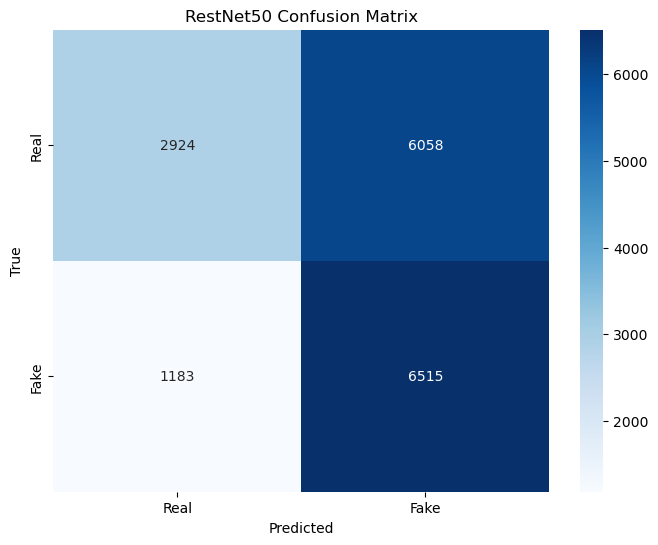

In [27]:
# Load test results
test_results = pd.read_csv("resnet_test_results.csv")
y_true = test_results["True Labels"].values
y_pred_probs = test_results["Probabilities"].values

# Convert probabilities to binary predictions
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Extract TN, FP, FN, TP
tn, fp, fn, tp = conf_matrix.ravel()

# Print the confusion matrix with labels
print("ResNet50 Confusion Matrix:")
print(f"TN (True Negatives): {tn}")
print(f"FP (False Positives): {fp}")
print(f"FN (False Negatives): {fn}")
print(f"TP (True Positives): {tp}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("RestNet50 Confusion Matrix")

# Save the figure
plt.savefig("restnet_confusion_matrix.png", dpi=600, bbox_inches="tight")
plt.show()

### ResNet50 AUC-ROC Curve

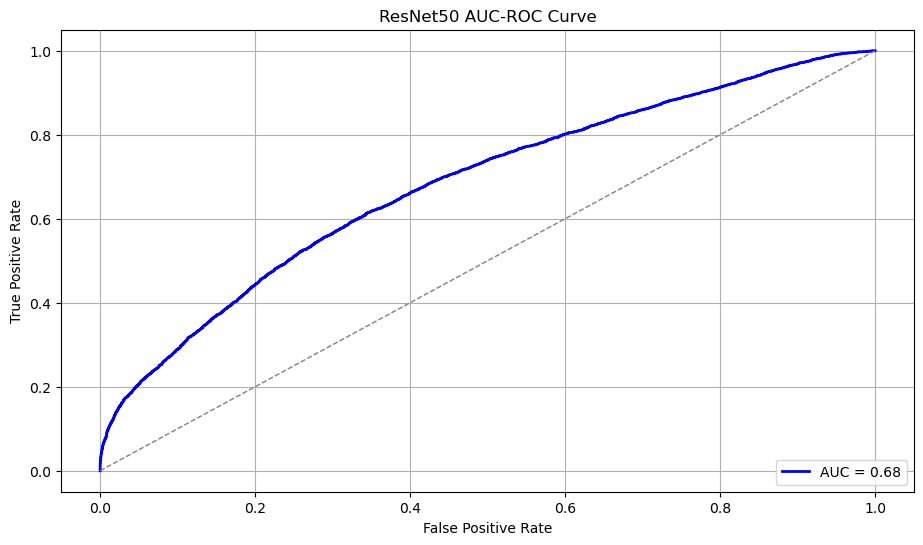

In [8]:
# Load test results
test_results = pd.read_csv("resnet_test_results.csv")
y_true = test_results["True Labels"].values
y_pred_probs = test_results["Probabilities"].values

# Compute ROC-AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(11, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ResNet50 AUC-ROC Curve")
plt.legend(loc="lower right")
plt.grid()

# Save the figure
plt.savefig("resnet_auc_roc_curve.png", dpi=600, bbox_inches="tight")
plt.show()

### ResNet50 Classification Report

In [21]:
# Load test results
test_results = pd.read_csv("resnet_test_results.csv")
y_true = test_results["True Labels"].values
y_pred_probs = test_results["Probabilities"].values

# Convert probabilities to binary predictions
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Generate Classification Report
print("ResNet50 Classification Report:\n")
print(classification_report(y_true, y_pred_labels, target_names=["Real", "Fake"]))

ResNet50 Classification Report:

              precision    recall  f1-score   support

        Real       0.71      0.33      0.45      8982
        Fake       0.52      0.85      0.64      7698

    accuracy                           0.57     16680
   macro avg       0.62      0.59      0.54     16680
weighted avg       0.62      0.57      0.54     16680



### ResNet50 Classification Report Heatmap

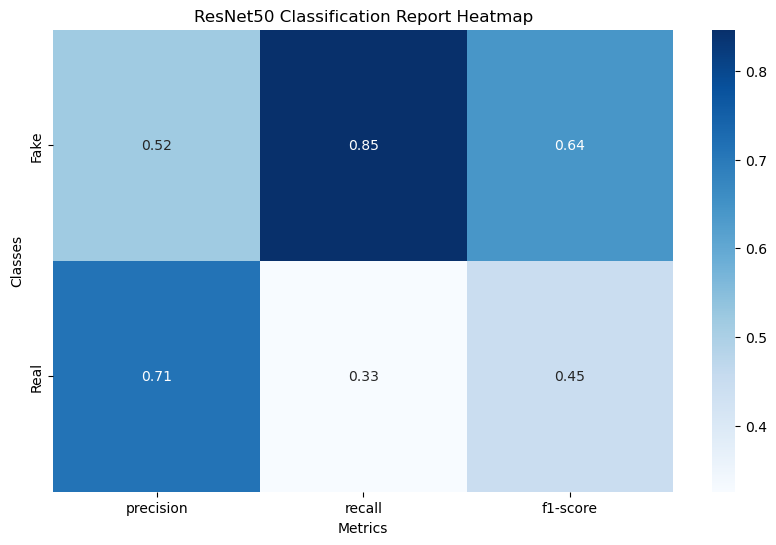

In [22]:
# Load test results
test_results = pd.read_csv("resnet_test_results.csv")
y_true = test_results["True Labels"].map({0: "Real", 1: "Fake"}).values
y_pred = test_results["Predicted"].map({0: "Real", 1: "Fake"}).values

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Convert classification report to DataFrame
report_df = pd.DataFrame(report).transpose()

# Filter out "accuracy", "macro avg", and "weighted avg" for better visualization
filtered_report = report_df.drop(index=["accuracy", "macro avg", "weighted avg"])

# Plot classification report as a heatmap with a color bar
plt.figure(figsize=(10, 6))
sns.heatmap(
    filtered_report.iloc[:, :-1],
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar=True
)
plt.title("ResNet50 Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")

# Save the figure
plt.savefig("restnet_classification_heatmap.png", dpi=600, bbox_inches="tight")
plt.show()

### 7.2 Testing EfficientnetV2B0 Final Trained Model

In [6]:
# Configure GPU to allow memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled GPU memory growth.")
    except RuntimeError as e:
        print("Error setting GPU memory growth:", e)

# Testing EfficientNetV2B0 Final Model
print("--- Testing EfficientNetV2B0 Final Model ---")

# Paths and Parameters
test_dir = os.path.join(base_dir, "Cropped_Faces", "test")
TEST_BATCH_SIZE = 8  # Batch size for inference
TEST_SEQUENCE_LENGTH = 10  # Sequence length expected by the model
TEST_TARGET_SIZE = (224, 224)  # Input size for the model

# Load the saved model once
model_path = "efficientnet_model.h5"
print("Loading model...")
efficientnet_final_model = load_model(model_path)
print("EfficientNetV2B0 Final model loaded successfully.")

# **Evaluation**
y_true, y_pred_probs, y_pred_labels = [], [], []

print("\n--- Evaluating the Model on the Test Dataset ---")
test_generator = non_stratified_data_generator(
    data_dir=test_dir,
    batch_size=TEST_BATCH_SIZE,
    sequence_length=TEST_SEQUENCE_LENGTH,
    target_size=TEST_TARGET_SIZE
)

for step, (X_batch, y_batch) in enumerate(test_generator):
    # Ensure batch shape compatibility
    X_batch = tf.reshape(X_batch, [-1, TEST_SEQUENCE_LENGTH, *TEST_TARGET_SIZE, 3])

    # Perform prediction
    batch_probs = efficientnet_final_model.predict(X_batch, batch_size=TEST_BATCH_SIZE).flatten()

    # Store results
    y_pred_probs.extend(batch_probs.tolist())
    y_pred_labels.extend((batch_probs > 0.5).astype(int).tolist())  # Binary threshold
    y_true.extend(y_batch)

    # **Clear GPU Memory**
    print(f"Batch {step + 1} processed. Flushing GPU memory.")
    K.clear_session()  # Clear TensorFlow backend memory
    gc.collect()       # Trigger Python garbage collection

# Convert results to arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_labels = np.array(y_pred_labels)

# Save results to a CSV file
test_results = pd.DataFrame({
    "True Labels": y_true,
    "Predicted": y_pred_labels,
    "Probabilities": y_pred_probs
})
test_results.to_csv("efficientnet_test_results.csv", index=False)
print("Test results saved to 'efficientnet_test_results.csv'.")

# **Display Basic Statistics**
print(f"\n--- Test Evaluation Complete ---")
print(f"Total Samples Tested: {len(y_true)}")

Enabled GPU memory growth.
--- Testing EfficientNetV2B0 Final Model ---
Loading model...
EfficientNetV2B0 Final model loaded successfully.

--- Evaluating the Model on the Test Dataset ---

--- Initializing Non-Stratified Data Generator (For Testing) ---
Data Directory: C:\Users\atul\Cropped_Faces\test
Batch Size: 8, Sequence Length: 10, Target Size: (224, 224)

Scanning directory: C:\Users\atul\Cropped_Faces\test\real
Collected 89826 images for class 'real'.
Scanning directory: C:\Users\atul\Cropped_Faces\test\fake
Collected 86224 images for class 'fake'.

Image collection completed for all classes.
1/1 [==============================] - 12s 12s/step
Batch 1 processed. Flushing GPU memory.
1/1 [==============================] - 3s 3s/step
Batch 2 processed. Flushing GPU memory.
1/1 [==============================] - 3s 3s/step
Batch 3 processed. Flushing GPU memory.
1/1 [==============================] - 3s 3s/step
Batch 4 processed. Flushing GPU memory.
1/1 [=========================

### EfficientnetV2B0 Confusion Matrix

EfficientnetV2B0 Confusion Matrix:
TN (True Negatives): 4476
FP (False Positives): 4506
FN (False Negatives): 4268
TP (True Positives): 4350


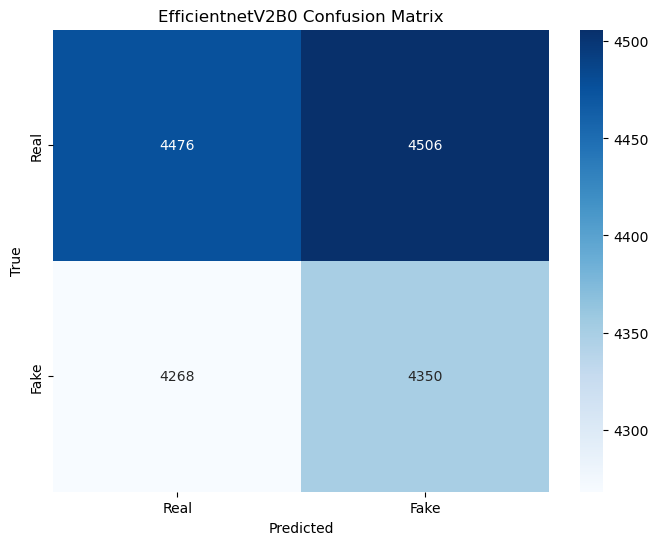

In [24]:
# Load test results
test_results = pd.read_csv("efficientnet_test_results.csv")
y_true = test_results["True Labels"].values
y_pred_probs = test_results["Probabilities"].values

# Convert probabilities to binary predictions
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Extract TN, FP, FN, TP
tn, fp, fn, tp = conf_matrix.ravel()

# Print the confusion matrix with labels
print("EfficientnetV2B0 Confusion Matrix:")
print(f"TN (True Negatives): {tn}")
print(f"FP (False Positives): {fp}")
print(f"FN (False Negatives): {fn}")
print(f"TP (True Positives): {tp}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("EfficientnetV2B0 Confusion Matrix")

# Save the figure
plt.savefig("efficientnet_confusion_matrix.png", dpi=600, bbox_inches="tight")
plt.show()

### EfficientnetV2B0 AUC-ROC Curve

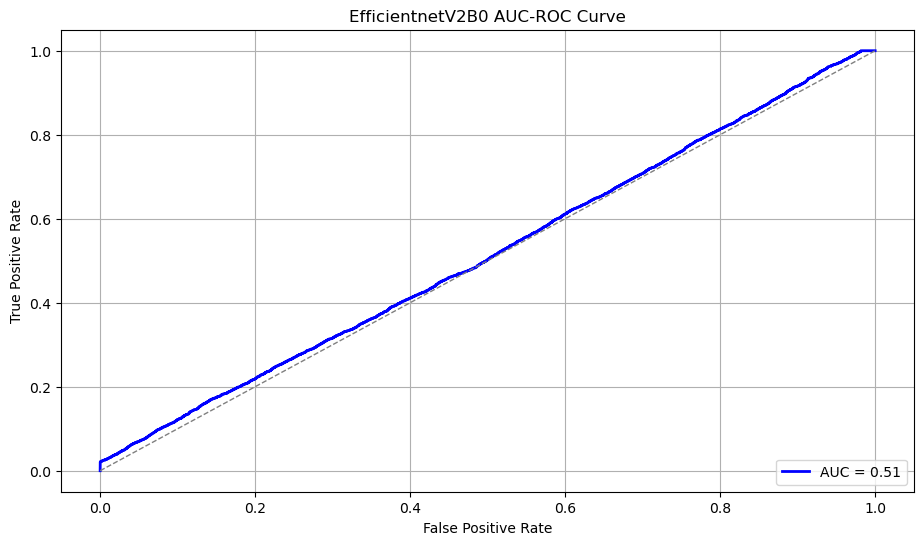

In [9]:
# Load test results
test_results = pd.read_csv("efficientnet_test_results.csv")
y_true = test_results["True Labels"].values
y_pred_probs = test_results["Probabilities"].values

# Compute ROC-AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(11, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("EfficientnetV2B0 AUC-ROC Curve")
plt.legend(loc="lower right")
plt.grid()

# Save the figure
plt.savefig("efficientnet_auc_roc_curve.png", dpi=600, bbox_inches="tight")
plt.show()

### EfficientnetV2B0 Classification Report

In [25]:
# Load test results
test_results = pd.read_csv("efficientnet_test_results.csv")
y_true = test_results["True Labels"].values
y_pred_probs = test_results["Probabilities"].values

# Convert probabilities to binary predictions
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Generate Classification Report
print("EfficientnetV2B0 Classification Report:\n")
print(classification_report(y_true, y_pred_labels, target_names=["Real", "Fake"]))

EfficientnetV2B0 Classification Report:

              precision    recall  f1-score   support

        Real       0.51      0.50      0.51      8982
        Fake       0.49      0.50      0.50      8618

    accuracy                           0.50     17600
   macro avg       0.50      0.50      0.50     17600
weighted avg       0.50      0.50      0.50     17600



### EfficientnetV2B0 Classification Report Heatmap

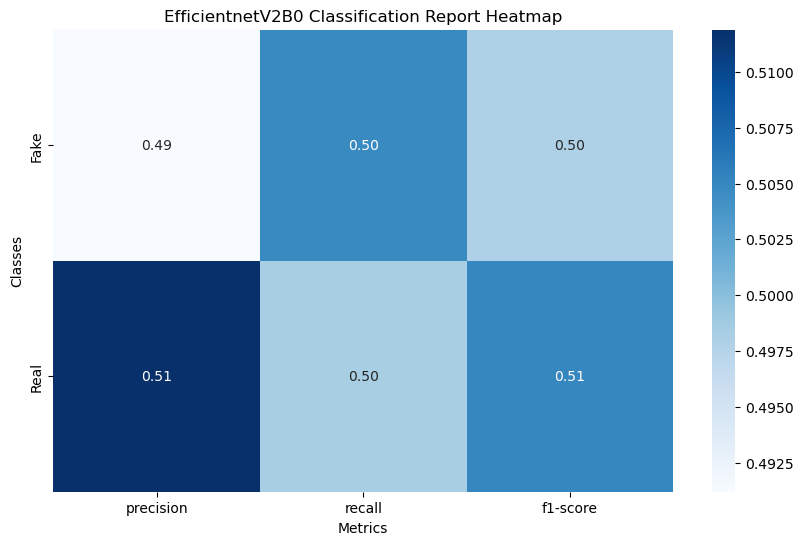

In [26]:
# Load test results
test_results = pd.read_csv("efficientnet_test_results.csv")
y_true = test_results["True Labels"].map({0: "Real", 1: "Fake"}).values
y_pred = test_results["Predicted"].map({0: "Real", 1: "Fake"}).values

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Convert classification report to DataFrame
report_df = pd.DataFrame(report).transpose()

# Filter out "accuracy", "macro avg", and "weighted avg" for better visualization
filtered_report = report_df.drop(index=["accuracy", "macro avg", "weighted avg"])

# Plot classification report as a heatmap with a color bar
plt.figure(figsize=(10, 6))
sns.heatmap(
    filtered_report.iloc[:, :-1],
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar=True
)
plt.title("EfficientnetV2B0 Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")

# Save the figure
plt.savefig("efficientnet_classification_heatmap.png", dpi=600, bbox_inches="tight")
plt.show()

### 7.3 Testing Xception Final Trained Model

In [9]:
# Configure GPU to allow memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Enabled GPU memory growth.")
    except RuntimeError as e:
        print("Error setting GPU memory growth:", e)

# Testing Xception Final Model
print("--- Testing Xception Final Model ---")

# Paths and Parameters
test_dir = os.path.join(base_dir, "Cropped_Faces", "test")
TEST_BATCH_SIZE = 5  # Batch size for inference
TEST_SEQUENCE_LENGTH = 5  # Sequence length expected by the model
TEST_TARGET_SIZE = (224, 224)  # Input size for the model

# Load the saved model once
model_path = "xception_model.h5"
print("Loading model...")
xception_final_model = load_model(model_path)
print("Xception Final model loaded successfully.")

# **Evaluation**
y_true, y_pred_probs, y_pred_labels = [], [], []

print("\n--- Evaluating the Model on the Test Dataset ---")
test_generator = non_stratified_data_generator(
    data_dir=test_dir,
    batch_size=TEST_BATCH_SIZE,
    sequence_length=TEST_SEQUENCE_LENGTH,
    target_size=TEST_TARGET_SIZE
)

for step, (X_batch, y_batch) in enumerate(test_generator):
    # Ensure batch shape compatibility
    X_batch = tf.reshape(X_batch, [-1, TEST_SEQUENCE_LENGTH, *TEST_TARGET_SIZE, 3])

    # Perform prediction
    batch_probs = xception_final_model.predict(X_batch, batch_size=TEST_BATCH_SIZE).flatten()

    # Store results
    y_pred_probs.extend(batch_probs.tolist())
    y_pred_labels.extend((batch_probs > 0.5).astype(int).tolist())  # Binary threshold
    y_true.extend(y_batch)

    # **Clear GPU Memory**
    print(f"Batch {step + 1} processed. Flushing GPU memory.")
    K.clear_session()  # Clear TensorFlow backend memory
    gc.collect()       # Trigger Python garbage collection

# Convert results to arrays
y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)
y_pred_labels = np.array(y_pred_labels)

# Save results to a CSV file
test_results = pd.DataFrame({
    "True Labels": y_true,
    "Predicted": y_pred_labels,
    "Probabilities": y_pred_probs
})
test_results.to_csv("xception_test_results.csv", index=False)
print("Test results saved to 'xception_test_results.csv'.")

# **Display Basic Statistics**
print(f"\n--- Test Evaluation Complete ---")
print(f"Total Samples Tested: {len(y_true)}")

Enabled GPU memory growth.
--- Testing Xception Final Model ---
Loading model...
Xception Final model loaded successfully.

--- Evaluating the Model on the Test Dataset ---

--- Initializing Non-Stratified Data Generator (For Testing) ---
Data Directory: C:\Users\atul\Cropped_Faces\test
Batch Size: 5, Sequence Length: 5, Target Size: (224, 224)

Scanning directory: C:\Users\atul\Cropped_Faces\test\real
Collected 89826 images for class 'real'.
Scanning directory: C:\Users\atul\Cropped_Faces\test\fake
Collected 86224 images for class 'fake'.

Image collection completed for all classes.
1/1 [==============================] - 9s 9s/step
Batch 1 processed. Flushing GPU memory.
1/1 [==============================] - 2s 2s/step
Batch 2 processed. Flushing GPU memory.
1/1 [==============================] - 2s 2s/step
Batch 3 processed. Flushing GPU memory.
1/1 [==============================] - 2s 2s/step
Batch 4 processed. Flushing GPU memory.
1/1 [==============================] - 2s 2s/step

### Xception Confusion Matrix

Xception Confusion Matrix:
TN (True Negatives): 11380
FP (False Positives): 6585
FN (False Negatives): 1434
TP (True Positives): 15811


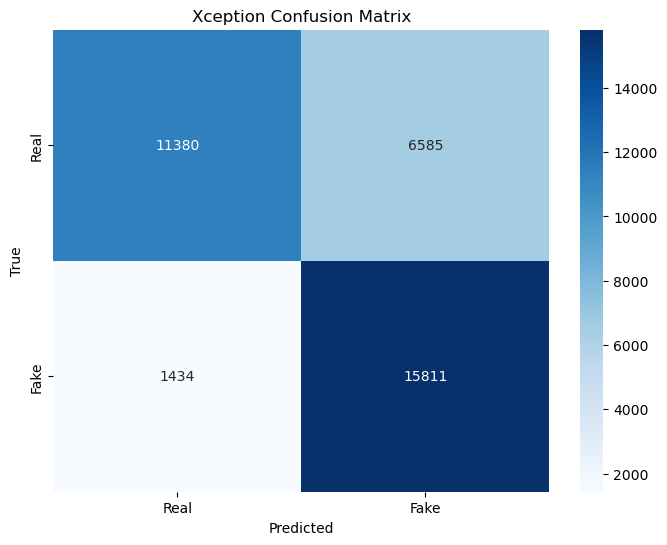

In [18]:
# Load test results
test_results = pd.read_csv("xception_test_results.csv")
y_true = test_results["True Labels"].values
y_pred_probs = test_results["Probabilities"].values

# Convert probabilities to binary predictions
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)

# Extract TN, FP, FN, TP
tn, fp, fn, tp = conf_matrix.ravel()

# Print the confusion matrix with labels
print("Xception Confusion Matrix:")
print(f"TN (True Negatives): {tn}")
print(f"FP (False Positives): {fp}")
print(f"FN (False Negatives): {fn}")
print(f"TP (True Positives): {tp}")

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Xception Confusion Matrix")

# Save the figure
plt.savefig("xception_confusion_matrix.png", dpi=600, bbox_inches="tight")
plt.show()

### Xception AUC-ROC Curve

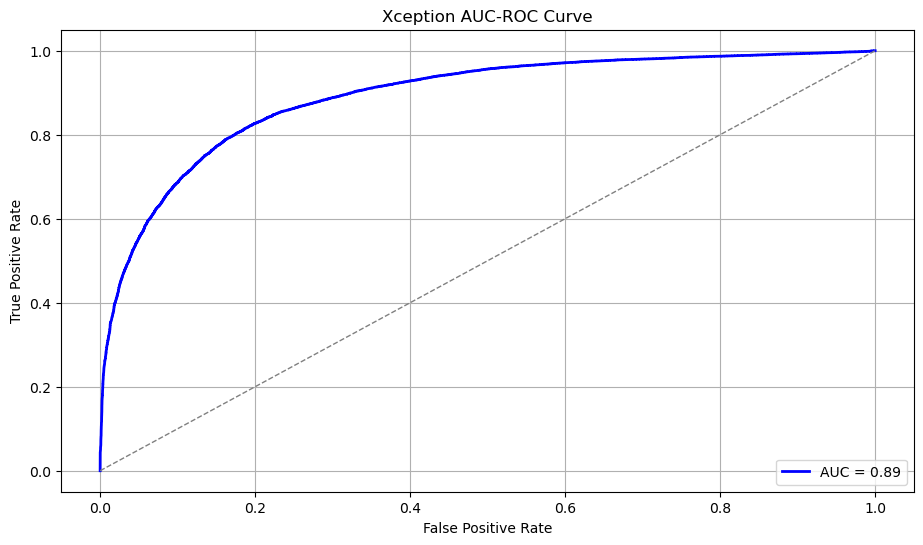

In [10]:
# Load test results
test_results = pd.read_csv("xception_test_results.csv")
y_true = test_results["True Labels"].values
y_pred_probs = test_results["Probabilities"].values

# Compute ROC-AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(11, 6))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Xception AUC-ROC Curve")
plt.legend(loc="lower right")
plt.grid()

# Save the figure
plt.savefig("xception_auc_roc_curve.png", dpi=600, bbox_inches="tight")
plt.show()

### Xception Classification Report

In [14]:
# Load test results
test_results = pd.read_csv("xception_test_results.csv")
y_true = test_results["True Labels"].values
y_pred_probs = test_results["Probabilities"].values

# Convert probabilities to binary predictions
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Generate Classification Report
print("Xception Classification Report:\n")
print(classification_report(y_true, y_pred_labels, target_names=["Real", "Fake"]))

Xception Classification Report:

              precision    recall  f1-score   support

        Real       0.89      0.63      0.74     17965
        Fake       0.71      0.92      0.80     17245

    accuracy                           0.77     35210
   macro avg       0.80      0.78      0.77     35210
weighted avg       0.80      0.77      0.77     35210



### Xception Classification Report Heatmap

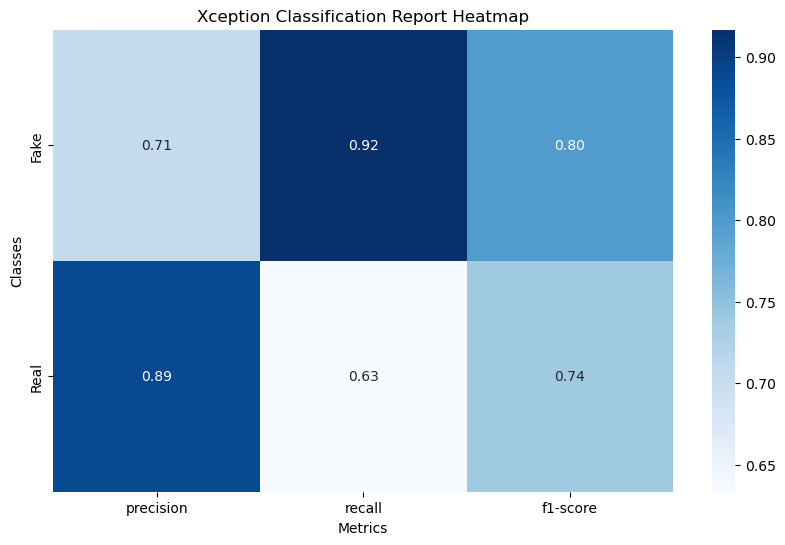

In [15]:
# Load test results
test_results = pd.read_csv("xception_test_results.csv")
y_true = test_results["True Labels"].map({0: "Real", 1: "Fake"}).values
y_pred = test_results["Predicted"].map({0: "Real", 1: "Fake"}).values

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)

# Convert classification report to DataFrame
report_df = pd.DataFrame(report).transpose()

# Filter out "accuracy", "macro avg", and "weighted avg" for better visualization
filtered_report = report_df.drop(index=["accuracy", "macro avg", "weighted avg"])

# Plot classification report as a heatmap with a color bar
plt.figure(figsize=(10, 6))
sns.heatmap(
    filtered_report.iloc[:, :-1],
    annot=True,
    fmt=".2f",
    cmap="Blues",
    cbar=True
)
plt.title("Xception Classification Report Heatmap")
plt.xlabel("Metrics")
plt.ylabel("Classes")

# Save the figure
plt.savefig("xception_classification_heatmap.png", dpi=600, bbox_inches="tight")
plt.show()